# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools

In [4]:
import gvar as gv

In [5]:
# %matplotlib widget

In [6]:
%matplotlib notebook

### Gather observables

In [86]:
def f_get_plaquette(fname,dict1):
    
    try: 
        cmd="grep 'Plaquette' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string        

        arr=np.array([[int(i.split('[ ')[-1].split(' ]')[0]), np.float64(i.split(' ')[-1])] 
                         for i in op])
        
        dict1['Plaquette']=arr[:,1]
        dict1['iter'] = arr[:,0]
        
    except Exception as e: 
        print("Couldn't extract Plaquette values")
        print(e)
    
    return dict1

def f_get_polyakov(fname,dict1):
    
    try: 
        cmd="grep 'Polyakov' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        arr=[]
        for i in op: 
            strg=i.split(' ')[-1][1:-1]
            arr.append(complex(np.float64(strg.split(',')[0]),np.float64(strg.split(',')[1])))
    
        dict1['Polyakov']=arr

    except Exception as e: 
        print("Couldn't extract Polyakov values")
        print(e)
    
    return dict1


def f_get_traj_time(fname,dict1):
    
    try: 
        cmd="grep 'Total time for trajectory' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string
        
        arr=[np.float32(i.split(': ')[-1]) for i in op]
        dict1['Traj_time']=arr

    except Exception as e: 
        print("Couldn't extract total Traj times")
        print(e)
        
    return dict1



def f_get_metropolis(fname,dict1,lgth):
    
    try: 
        cmd="grep 'Metropolis_test' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        ## Other arrays have equilibriation data, metropolis doesn't. So we need to add nans to make them the same size
        arr_temp=[1 if (i.split(' ')[-1]=='ACCEPTED') else 0 for i in op] # Accept =1 , Reject = 0
        skip=lgth-len(arr_temp)
        arr_skip=[np.nan for i in range(skip)]
        arr=np.array(arr_skip+arr_temp)
        dict1['Accept']=arr

    except Exception as e: 
        print("Couldn't extract total Metropolis info")
        print(e)
    
    return dict1

def f_parse_grid_data(fname):
    
    dict1={}
    
    f_get_plaquette(fname,dict1)
    
    f_get_polyakov(fname,dict1)
    
    f_get_traj_time(fname,dict1)

    lgth = min([len(i) for i in dict1.values()])
    f_get_metropolis(fname,dict1,lgth)

    ## Store in DataFrame
    df=pd.DataFrame([])
    for key in dict1.keys():
        df[key]=pd.Series(dict1[key])
        
    return df

# df=f_parse_grid_data(fname)

In [87]:


def f_moments(y,L):
    ''' Compute susceptibility and Kurtosis for observables'''
    
    m=[gv.gvar(0,0) for i in range(5)]  # List to store moments
    m[0]=gv.gvar(1,1e-16) # zeroth moment is 1
    for i in range(1,5):
        m[i]=gv.dataset.avg_data(y**i)
        
    ## Check moments obtained by gvar, with direct calculation
#     n=[gv.gvar(0,0) for i in range(5)]  # List to store moments
#     n[0]=gv.gvar(1,1e-16) # zeroth moment is 1
#     for i in range(1,5):
#         arr=y**i
#         n[i]=gv.gvar(np.mean(arr),np.std(arr)/np.sqrt(arr.shape[0]))
    
#     print(m)
#     print(n)

    sus=(L**3)*(m[2]-(m[1]**2))
#     print(sus)

    if gv.mean(sus)>1e-12: # Don't measure if sus is 0
        kurt=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)
    else:
        kurt=gv.gvar(np.nan,np.nan)
        
    return sus,kurt


def f_get_summary_data(df,L,dict1):
    drop_idx=0
    
    ## Plaquette 
    y=df.Plaquette.values[drop_idx:]
    dict1['plaq'] = gv.dataset.avg_data(y)
    
    # Susceptibility and Binder cumulant
    dict1['sus_plaq'],dict1['kurt_plaq']=f_moments(y,L)
    
    ## Polyakov Loop
    y=np.abs(df.Polyakov.values[drop_idx:])
    dict1['polyakov']=gv.dataset.avg_data(y)
    
    # Susceptibility and Binder cumulant
    dict1['sus_poly'],dict1['kurt_poly']=f_moments(y,L)

    
    ## Trajectory time
    y=df.Traj_time.values[drop_idx:]
    dict1['traj_time']=gv.dataset.avg_data(y)
    
    
    ## Acceptance info
    y=df['Accept'].dropna().values
    Act=y[y==1].shape[0]
    Rjt=y[y==0].shape[0]
    accpt=Act* 100 /(Act+Rjt)

    dict1['accept']=accpt
    
    return dict1



$$ \chi_\mathcal{O} = L^3 \left[ \langle \mathcal{O}^2 \rangle - {(\langle \mathcal{O} \rangle )}^2 \right] $$ 

$$ \kappa_\mathcal{O} = \frac{\langle \mathcal{O}^4 \rangle - 4 \langle \mathcal{O}^3 \rangle \langle \mathcal{O} \rangle +6 \langle \mathcal{O}^2 \rangle {\langle \mathcal{O} \rangle} ^2 - 3 {\langle \mathcal{O} \rangle}^4 }{\chi_\mathcal{O}^2}$$ 

In [94]:

L=16
data_dict={}
df_summary=pd.DataFrame([])

top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/'

flist=glob.glob(top_dir+'run_Lx-%s_Lt-8*'%(L))
# print(flist)

for run_fldr in flist: 
    fname=run_fldr+'/HSDM.out'
#     print(fname)
    
    if not os.path.isfile(fname): 
        print("File %s doesn't exist"%(fname))
        continue
        
    df=f_parse_grid_data(fname)
#     display(df)
    
    beta = float(fname.split('/')[-2].split('_')[-2].split('-')[-1])
    mf   = float(fname.split('/')[-2].split('_')[-1].split('-')[-1])
    
    key='beta-%s_mf-%s'%(beta,mf)
    data_dict[key]=df
    
    # Get summary data
    dict2={'beta':beta, 'mf':mf}
    dict2=f_get_summary_data(df,L,dict2)
        
    df_summary=pd.concat([df_summary,pd.DataFrame(dict2,index=[df_summary.shape[0]+1])])    
    
df_summary=df_summary.sort_values(by=['beta','mf']).reset_index(drop=True)
display(df_summary)


,beta,mf,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,accept
0,8.00,0.6443,0.2930(19),3.2(8.1),5(148)e-06,0.00378(40),0.14(13),9(21)e-06,14.7140(34),98.5
1,9.00,0.4443,0.3481(22),4(11),3(140)e-06,0.00439(69),0.40(34),8(16)e-06,15.8448(35),97.0
2,9.00,0.6443,0.3477(22),4(10),3(142)e-06,0.00450(68),0.39(34),8(16)e-06,14.5230(81),98.0
3,9.00,0.8443,0.3475(22),4(10),3(144)e-06,0.00444(67),0.39(33),8(16)e-06,13.8639(46),98.5
4,10.00,0.6443,0.4333(24),5(13),1(173)e-06,0.0061(11),0.96(66),5.0(8.5)e-06,14.5313(52),93.5
5,10.25,0.6443,0.4754(20),4(12),1(354)e-06,0.0068(12),1.20(76),4.2(6.7)e-06,14.5383(68),93.5
6,10.50,0.4443,0.5414(10),0.9(6.7),3(4073)e-06,0.0092(13),1.54(87),3.3(4.9)e-06,15.9655(37),96.0
7,10.50,0.6443,0.5384(11),1.0(6.9),3(3691)e-06,0.0089(13),1.50(86),3.3(5.1)e-06,14.1832(54),97.0
8,10.50,0.8443,0.5355(11),1.0(7.1),3(3296)e-06,0.0088(13),1.47(85),3.4(5.2)e-06,13.4647(56),96.0
9,10.75,0.6443,0.56320(86),0.6(5.8),4(7642)e-06,0.0157(15),1.85(98),2.4(3.7)e-06,14.2559(37),98.0


## Summary plots

### Plot Polyakov loop vs $m_f$ for different $\beta$

In [95]:
mf_list   = np.sort(np.unique(df_summary.mf.values))
beta_list = np.sort(np.unique(df_summary.beta.values))

<IPython.core.display.Javascript object>


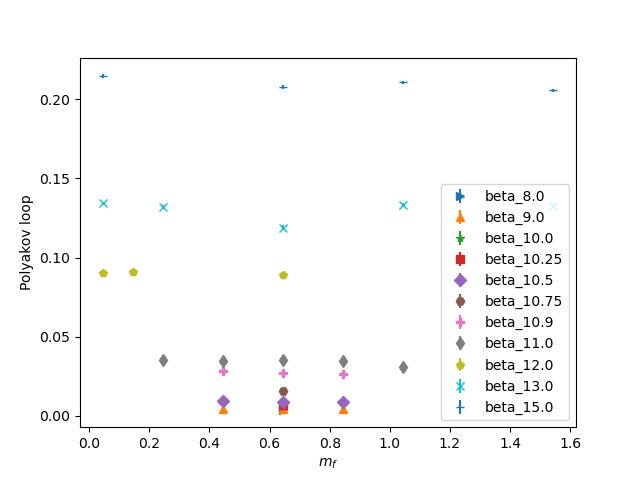

Text(0, 0.5, 'Polyakov loop')

In [96]:
plt.figure()

for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

    label='beta_%s'%(beta)
    df1=df_summary[df_summary.beta==beta].sort_values(by=['mf'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.mf.values
    y=df1.polyakov.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.xlabel(r'$m_f$')
# plt.xticks(mf_list)
# plt.xlim(-0.5,2.0)
plt.legend(loc='best')
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.savefig('Ploop_vs_mf.pdf')

### Plot Polyakov loop vs $\beta$ for different $m_f$

<IPython.core.display.Javascript object>


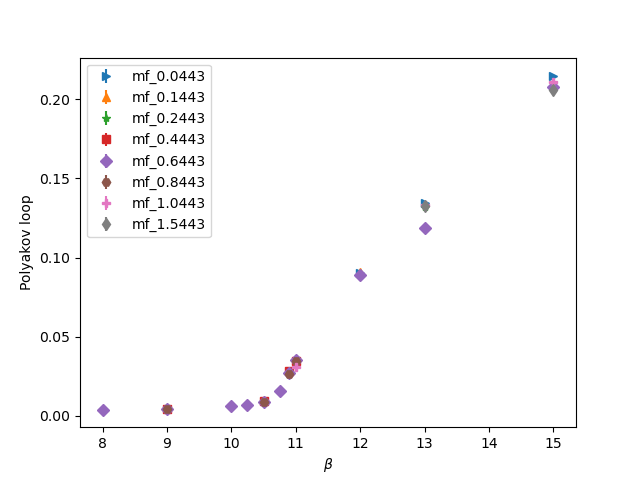

In [97]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.polyakov.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
plt.savefig('Ploop_vs_beta.pdf')

### Plot Susceptibility

<IPython.core.display.Javascript object>


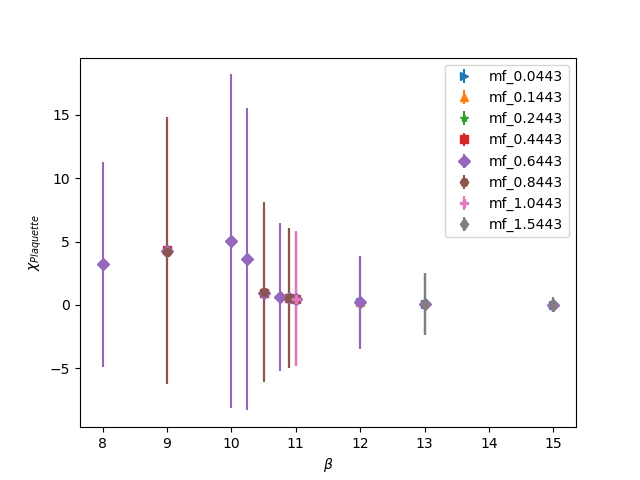

In [98]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.sus_plaq.values
    
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Plaquette}$',rotation='vertical')
plt.savefig('chi_plaq_vs_beta.pdf')

<IPython.core.display.Javascript object>


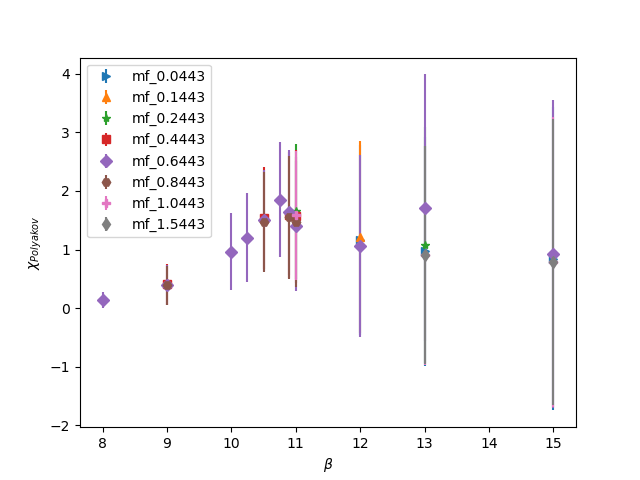

In [101]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.sus_poly.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Polyakov}$',rotation='vertical')
plt.savefig('chi_poly_vs_beta.pdf')

<IPython.core.display.Javascript object>


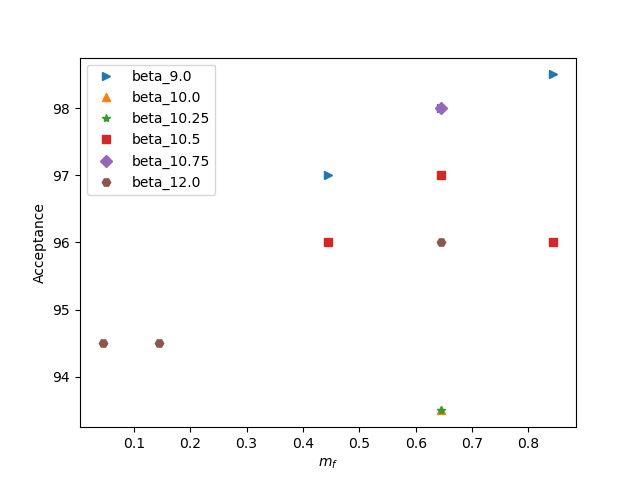

Text(0, 0.5, 'Acceptance')

In [104]:
# Plot acceptance rate 

plt.figure()

for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

    label='beta_%s'%(beta)
    df1=df_summary[df_summary.beta==beta].sort_values(by=['mf'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.mf.values
    y=df1.accept.values
#     print(x,y)
    plt.plot(x,y,linestyle='',label=label,marker=marker)
#     plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.xlabel(r'$m_f$')
# plt.xticks(mf_list)
# plt.xlim(-0.5,2.0)
plt.legend(loc='best')
plt.ylabel('Acceptance',rotation='vertical')
# plt.savefig('Acceptance_vs_mf.pdf')

## Individual plots

<IPython.core.display.Javascript object>


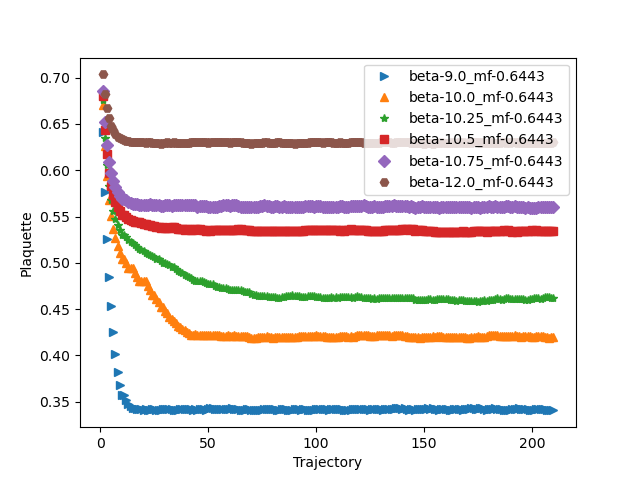

beta-9.0_mf-0.6443
beta-10.0_mf-0.6443
beta-10.25_mf-0.6443
beta-10.5_mf-0.6443
beta-10.75_mf-0.6443
beta-12.0_mf-0.6443


<IPython.core.display.Javascript object>


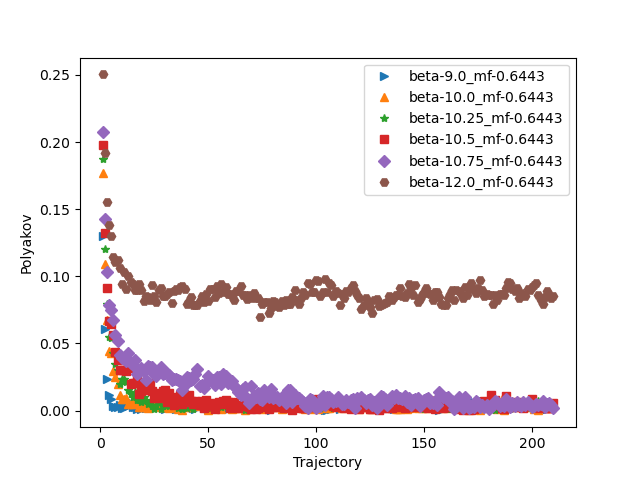

beta-9.0_mf-0.6443
beta-10.0_mf-0.6443
beta-10.25_mf-0.6443
beta-10.5_mf-0.6443
beta-10.75_mf-0.6443
beta-12.0_mf-0.6443


In [105]:

def f_plot_specific_runs(data_dict,column,beta_list,mf_list):
    ''' Plot behavior of quantity in MC time
    col = Plaquette, Polyakov, Traj_time, Accept, Plaq_epoch'''
    
    ## Gather dict keys with given beta and mf values
    keys_list=['beta-%s_mf-%s'%(b,m) for m in mf_list for b in beta_list]
    
    assert len(keys_list)>0 ,"Shortened list has 0 elements" 
    
    plt.figure()

    for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):

        df=data_dict[i]
        label=i
        print(label)
        x=df.iter.values
        if column=='Polyakov':
            y=np.abs(df[column].values)
        else:
            y=df[column].values

        plt.plot(x,y,linestyle='',label=label, marker=marker)

    plt.legend(loc='best')
    plt.ylabel(column)
    plt.xlabel('Trajectory')
    plt.show()
    
    
beta_list=[9.0,10.0,10.25, 10.5, 10.75,12.0]
# beta_list=[10.75,12.0]
mf_list=[0.6443]

# beta_list=[10.0,11.0,12.0]
# mf_list=[0.6443,0.8443]

f_plot_specific_runs(data_dict,'Plaquette',beta_list,mf_list)
plt.savefig('Plaq_details.pdf')

# f_plot_specific_runs(dict_list,'Traj_time',beta_list,mf_list)

f_plot_specific_runs(data_dict,'Polyakov',beta_list,mf_list)
plt.savefig('Polyakov_details.pdf')


<IPython.core.display.Javascript object>


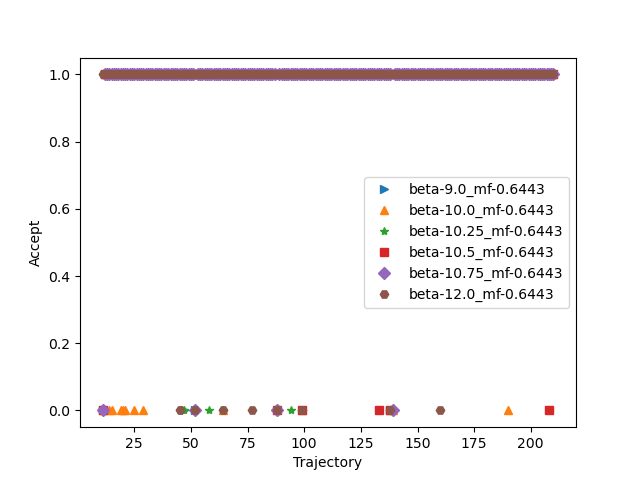

beta-9.0_mf-0.6443
beta-10.0_mf-0.6443
beta-10.25_mf-0.6443
beta-10.5_mf-0.6443
beta-10.75_mf-0.6443
beta-12.0_mf-0.6443


In [108]:
f_plot_specific_runs(data_dict,'Accept',beta_list,mf_list)


### Plot Polyakov loop

In [110]:
# fig=plt.figure()

# for i in dict_list:
#     df=i['df']
#     label=i['beta']+'_'+i['mf']
# #     print(label)
    
    
#     x=df.iter.values
#     y=df.Polyakov.values
#     fig.add_subplot(2,1,1)

#     plt.plot(x,y.real,marker='o',linestyle='',label=label)
#     plt.ylabel('Real Polyakov loop')

#     fig.add_subplot(2,1,2)

#     plt.plot(x,y.imag,marker='o',linestyle='',label=label)
    
# plt.legend(loc='best')
# plt.ylabel('Imag Polyakov loop')
# plt.show()


<IPython.core.display.Javascript object>


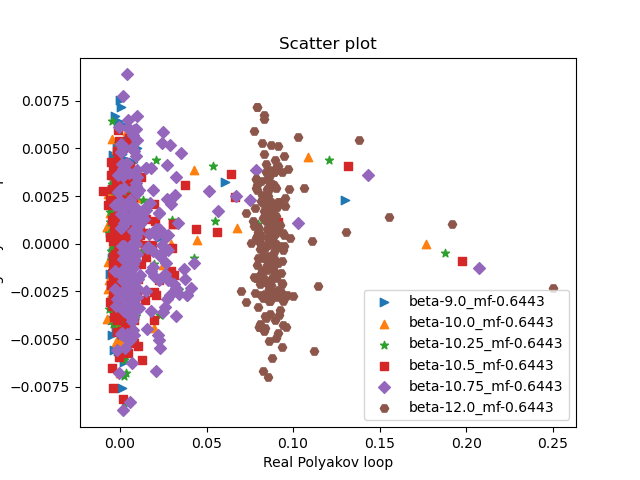

beta-9.0_mf-0.6443
beta-10.0_mf-0.6443
beta-10.25_mf-0.6443
beta-10.5_mf-0.6443
beta-10.75_mf-0.6443
beta-12.0_mf-0.6443


In [112]:
keys_list=['beta-%s_mf-%s'%(b,m) for m in mf_list for b in beta_list]


fig=plt.figure()

for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):
    df=data_dict[i]
    label=i
    print(label)

    x=df.iter.values
    y=df.Polyakov.values

    y1=y.real
    y2=y.imag

    plt.scatter(y1,y2,label=label,marker=marker)
    
plt.legend(loc='best')
plt.xlabel('Real Polyakov loop')
plt.ylabel('Imag Polyakov loop')
plt.title("Scatter plot")
plt.show()

<IPython.core.display.Javascript object>


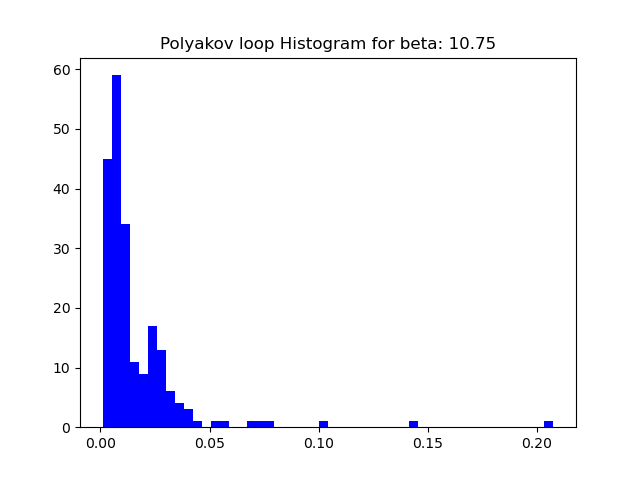

In [113]:
# Histogram
beta=10.75
mf=0.6443
key='beta-%s_mf-%s'%(beta,mf)

df=data_dict[key]

fig=plt.figure()
x=df.iter.values[:210]
y=np.abs(df.Polyakov.values[:210])

# hist,bins=np.histogram(y,bins=10)
# plt.bar(np.linspace(0,0.3,10),hist)
# plt.stairs(hist)

plt.hist(y,bins=50,color='b')

plt.title("Polyakov loop Histogram for beta: %s"%(beta))
plt.savefig('ploop_histogram.pdf')